In [1]:
#回归分析

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader,TensorDataset
import time
strat = time.perf_counter()

#读取训练数据和测试数据
o_train = pd.read_csv('./回归分析/train.csv')
o_test = pd.read_csv('./回归分析/test.csv')

#自己的数据集，需要对原始数据进行处理
#原数据 第一列是序号， 从第二列到导数第二列都是 维度，最后一列是房价
#对各维度的预处理(标准化)方式：数值型的转为[-1,1]之间 z-score 标准化，新数据=（原数据-均值）/标准差
#非数值型中的  无序型进行独热编码(one-hot encoding)，有序型 自己定义其数值 转换为数值型  本数据集默认全部为无序型
#空值：每一个特征的全局平均值来代替无效值

#将训练集与测试集的特征数据合并在一起 统一进行处理
#loc：通过行标签索引数据 iloc：通过行号索引行数据 ix：通过行标签或行号索引数据（基于loc和iloc的混合）

#合并数据集
all_features = pd.concat((o_train.loc[:,'Area':'Neighborhood'],o_test.loc[:,'Area':'Neighborhood']))
all_labels = pd.concat((o_train.loc[:,'Price'],o_test.loc[:,'Price']))

#对特征值进行数据预处理
#取出所有的数值型特征名称
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index
object_feats = all_features.dtypes[all_features.dtypes == "object"].index

# 将数值型特征进行 z-score 标准化
all_features[numeric_feats] = all_features[numeric_feats].apply(lambda x: (x - x.mean()) / (x.std()))

#对无序型进行one-hot encoding
all_features = pd.get_dummies(all_features,prefix=object_feats, dummy_na=True)

#空值：每一个特征的全局平均值来代替无效值 NA就是指空值
all_features = all_features.fillna(all_features.mean())

#对标签进行数据预处理
#对标签进行 z-score 标准化
mean = all_labels.mean()
std = all_labels.std()
all_labels = (all_labels - mean)/std

num_train = o_train.shape[0]
train_features = all_features[:num_train].values.astype(np.float32)#(1314, 331)
test_features = all_features[num_train:].values.astype(np.float32)#(146, 331)
train_labels = all_labels[:num_train].values.astype(np.float32)
test_labels = all_labels[num_train:].values.astype(np.float32)
#至此 输入数据准备完毕 可以看见 经过one-hot编码后  特征维度增加了很多 81->331

#数据类型转换，数组转换成张量
train_features = torch.from_numpy(train_features)
train_labels = torch.from_numpy(train_labels).unsqueeze(1)
test_features = torch.from_numpy(test_features)
test_labels = torch.from_numpy(test_labels).unsqueeze(1)
train_set = TensorDataset(train_features,train_labels)
test_set = TensorDataset(test_features,test_labels)

#设置迭代器
train_data = DataLoader(dataset=train_set,batch_size=64,shuffle=True)
test_data  = DataLoader(dataset=test_set,batch_size=64,shuffle=False)

#设置网络结构
class Net(torch.nn.Module):# 继承 torch 的 Module
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()     # 继承 __init__ 功能
        # 定义每层用什么样的形式
        self.layer1 = torch.nn.Linear(n_feature, 600)   #
        self.layer2 = torch.nn.Linear(600, 1200)   #
        self.layer3 = torch.nn.Linear(1200, n_output)

    def forward(self, x):   # 这同时也是 Module 中的 forward 功能
        x = self.layer1(x)
        x = torch.relu(x)      #
        x = self.layer2(x)
        x = torch.relu(x)      #
        x = self.layer3(x)
        return x
net = Net(44,1)

#反向传播算法 SGD Adam等
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
#均方损失函数
criterion =	torch.nn.MSELoss()

#记录用于绘图
losses = []#记录每次迭代后训练的loss
eval_losses = []#测试的

for i in range(100):
    train_loss = 0
    # train_acc = 0
    net.train() #网络设置为训练模式 暂时可加可不加
    for tdata,tlabel in train_data:
        #前向传播
        y_ = net(tdata)
        #记录单批次一次batch的loss
        loss = criterion(y_, tlabel)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #累计单批次误差
        train_loss = train_loss + loss.item()

    losses.append(train_loss / len(train_data))
    # 测试集进行测试
    eval_loss = 0
    net.eval()  # 可加可不加
    for edata, elabel in test_data:
        # 前向传播
        y_ = net(edata)
        # 记录单批次一次batch的loss，测试集就不需要反向传播更新网络了
        loss = criterion(y_, elabel)
        # 累计单批次误差
        eval_loss = eval_loss + loss.item()
    eval_losses.append(eval_loss / len(test_data))

    print('训练次数: {}, 训练集损失: {}, 测试集损失: {}'.format(i, train_loss / len(train_data), eval_loss / len(test_data)))

#测试最终模型的精准度，测试集的平均误差
y_ = net(test_features)
y_pre = y_ * std + mean
print('测试集预测值：',y_pre.squeeze().detach().cpu().numpy())
print('模型平均误差：',abs(y_pre - (test_labels*std + mean)).mean().cpu().item() )
end =time.perf_counter()
print('模型运行时间：',end - strat)

训练次数: 0, 训练集损失: 0.9273214893681663, 测试集损失: 0.6346924304962158
训练次数: 1, 训练集损失: 0.7335721339498248, 测试集损失: 0.5685611963272095
训练次数: 2, 训练集损失: 0.628623963821502, 测试集损失: 0.5188746452331543
训练次数: 3, 训练集损失: 0.5198375611078172, 测试集损失: 0.5036099553108215
训练次数: 4, 训练集损失: 0.4513648521332514, 测试集损失: 0.4900531768798828
训练次数: 5, 训练集损失: 0.4128928326425098, 测试集损失: 0.5260793566703796
训练次数: 6, 训练集损失: 0.38650059948364895, 测试集损失: 0.5539237856864929
训练次数: 7, 训练集损失: 0.3705218824602309, 测试集损失: 0.5842837691307068
训练次数: 8, 训练集损失: 0.350603325735955, 测试集损失: 0.5890238285064697
训练次数: 9, 训练集损失: 0.3470091408207303, 测试集损失: 0.5966953635215759
训练次数: 10, 训练集损失: 0.33050715852351414, 测试集损失: 0.6283127069473267
训练次数: 11, 训练集损失: 0.33346851595810484, 测试集损失: 0.6155019402503967
训练次数: 12, 训练集损失: 0.3236567150978815, 测试集损失: 0.628471314907074
训练次数: 13, 训练集损失: 0.32445557699317024, 测试集损失: 0.6315127015113831
训练次数: 14, 训练集损失: 0.3149875672090621, 测试集损失: 0.6268324255943298
训练次数: 15, 训练集损失: 0.30726257818085806, 测试集损失: 0.6249331831932068


In [2]:
#聚类分析

running k-means on cpu..


[running kmeans]: 8it [00:00, 462.36it/s, center_shift=0.000000, iteration=8, tol=0.000100]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1])
tensor([[6.8538, 3.0769, 5.7154, 2.0538],
        [5.8836, 2.7410, 4.3885, 1.4344],
        [5.0060, 3.4280, 1.4620, 0.2460]])


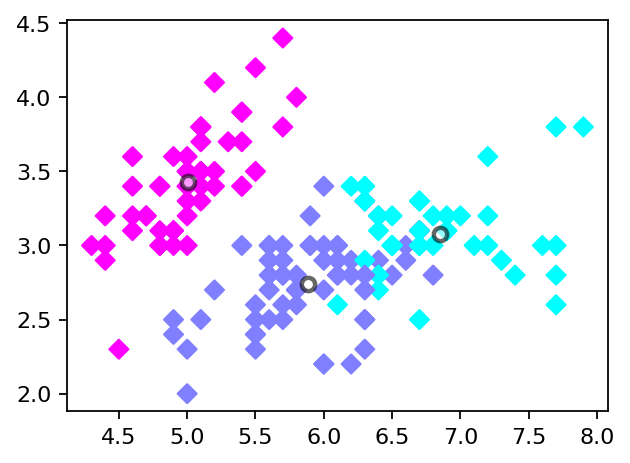

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kmeans_pytorch import kmeans
from torch.autograd import Variable
import torch.nn.functional as F

#设置运行环境
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
#获取数据
plant = pd.read_csv("./聚类分析/plant.csv")
#iris_d = iris[['Sepal_Length', 'Sepal_Width']]
plant_d = plant[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']]
plant['target'] = plant['Species']
x = torch.from_numpy(np.array(plant_d))
y = torch.from_numpy(np.array(plant.target))

#设置聚类数
num_clusters = 3

#设置聚类模型
cluster_ids_x, cluster_centers = kmeans(
    X=x, num_clusters=num_clusters, distance='euclidean', device=device
)    

#输出聚类ID和聚类中心点
print(cluster_ids_x)
print(cluster_centers)

#绘制散点图
plt.figure(figsize=(4, 3), dpi=160)
plt.scatter(x[:, 0], x[:, 1], c=cluster_ids_x, cmap='cool', marker="D")
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    c='white',
    alpha=0.6,
    edgecolors='black',
    linewidths=2
)
plt.tight_layout()
plt.show()

In [4]:
#主成分分析

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=3, bias=True)
)
Accuracy=0.45


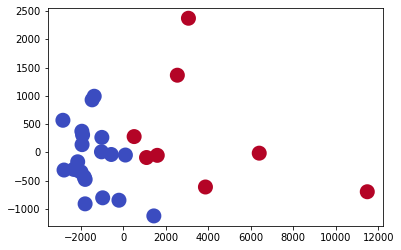

Accuracy=0.41


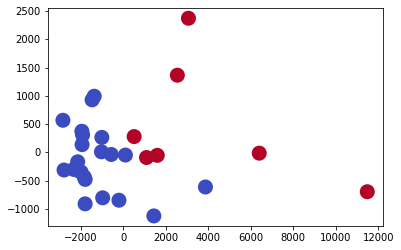

Accuracy=0.55


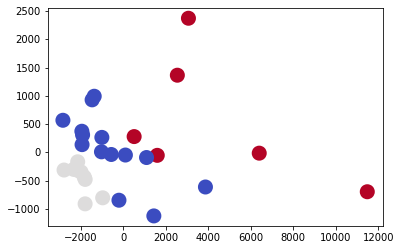

Accuracy=0.59


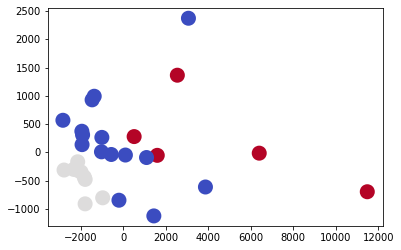

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.autograd import Variable
import torch.nn.functional as F

#读取数据
region = pd.read_csv("./主成分分析/region.csv")
region_d = region[['x1', 'x2', 'x3', 'x4']]
region['target'] = region['y']

#特征降维——主成分分析
transfer_1 = PCA(n_components=2)
region_d = transfer_1.fit_transform(region_d)
x = torch.from_numpy(region_d)
y =torch.from_numpy(np.array(region.target))
x, y = Variable(x), Variable(y)

#设置网络结构
net =torch.nn.Sequential(
    torch.nn.Linear(2, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 3),
    )
print(net)

#优化器，随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001)  
loss_func = torch.nn.CrossEntropyLoss()

#训练模型，循环100次，并进行可视化
for t in range(100):
    out = net(x.float())
    loss = loss_func(out, y.long())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 25 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.data.numpy()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=5, cmap='coolwarm')
        accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        print('Accuracy=%.2f' % accuracy)
        #plt.text(8.5, 8.8, 'Accuracy=%.2f' % accuracy, fontdict={'size': 15, 'color': 'red'})
        plt.pause(0.1)

    plt.show()

#保存网络及其参数
torch.save(net, './主成分分析/net.pkl')
torch.save(net.state_dict(), './主成分分析/net_params.pkl')

In [6]:
#模型评估与调优

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset   
import torch.nn.functional as F
from torch.autograd import Variable

#构造训练集
x = torch.rand(100,28,28) 
y = torch.randn(100,28,28)
x = torch.cat((x,y),dim=0)
label =[1] *100 + [0]*100  
label = torch.tensor(label,dtype=torch.long)

#设置网络结构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        self.fc1  = nn.Linear(28*28, 120) 
        self.fc2  = nn.Linear(120, 84)
        self.fc3  = nn.Linear(84, 2)
  
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        return x
    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#训练集处理
class TraindataSet(Dataset):
    def __init__(self,train_features,train_labels):
        self.x_data = train_features
        self.y_data = train_labels
        self.len = len(train_labels)
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    def __len__(self):
        return self.len

#设置损失函数
loss_func = nn.CrossEntropyLoss()

#设置K折划分
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  #slice(start,end,step)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    
    return X_train, y_train, X_valid,y_valid

def k_fold(k, X_train, y_train, num_epochs=3,learning_rate=0.001, weight_decay=0.1, batch_size=5):
    train_loss_sum, valid_loss_sum = 0, 0
    train_acc_sum ,valid_acc_sum = 0,0
    
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net =  Net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) 
       
        print('*'*10,'第',i+1,'折','*'*10)
        print('训练集损失:%.6f'%train_ls[-1][0],'训练集准确度:%.4f'%valid_ls[-1][1],\
              '测试集损失:%.6f'%valid_ls[-1][0],'测试集准确度:%.4f'%valid_ls[-1][1])
        train_loss_sum += train_ls[-1][0]
        valid_loss_sum += valid_ls[-1][0]
        train_acc_sum += train_ls[-1][1]
        valid_acc_sum += valid_ls[-1][1]
    print('#'*5,'最终k折交叉验证结果','#'*5)
    print('训练集累积损失:%.4f'%(train_loss_sum/k),'训练集累积准确度:%.4f'%(train_acc_sum/k),\
          '测试集累积损失:%.4f'%(valid_loss_sum/k),'测试集累积准确度:%.4f'%(valid_acc_sum/k))

#设置训练函数
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate,weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = TraindataSet(train_features, train_labels) 
    train_iter = DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(params=net.parameters(), lr= learning_rate, weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            output  = net(X)
            loss = loss_func(output,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        train_ls.append(log_rmse(0,net, train_features, train_labels)) 
        if test_labels is not None:
            test_ls.append(log_rmse(1,net, test_features, test_labels))

    return train_ls, test_ls

def log_rmse(flag,net,x,y):
    if flag == 1:
        net.eval()
    output = net(x)
    result = torch.max(output,1)[1].view(y.size())
    corrects = (result.data == y.data).sum().item()
    accuracy = corrects*100.0/len(y)
    loss = loss_func(output,y)
    net.train()
    
    return (loss.data.item(),accuracy)

#调用交叉验证函数
k_fold(10,x,label)

********** 第 1 折 **********
训练集损失:0.037964 训练集准确度:100.0000 测试集损失:0.039667 测试集准确度:100.0000
********** 第 2 折 **********
训练集损失:0.034622 训练集准确度:100.0000 测试集损失:0.024338 测试集准确度:100.0000
********** 第 3 折 **********
训练集损失:0.032369 训练集准确度:100.0000 测试集损失:0.023294 测试集准确度:100.0000
********** 第 4 折 **********
训练集损失:0.037431 训练集准确度:100.0000 测试集损失:0.025377 测试集准确度:100.0000
********** 第 5 折 **********
训练集损失:0.038406 训练集准确度:100.0000 测试集损失:0.031774 测试集准确度:100.0000
********** 第 6 折 **********
训练集损失:0.037817 训练集准确度:100.0000 测试集损失:0.314647 测试集准确度:100.0000
********** 第 7 折 **********
训练集损失:0.033933 训练集准确度:95.0000 测试集损失:0.371060 测试集准确度:95.0000
********** 第 8 折 **********
训练集损失:0.038424 训练集准确度:100.0000 测试集损失:0.419565 测试集准确度:100.0000
********** 第 9 折 **********
训练集损失:0.035169 训练集准确度:100.0000 测试集损失:0.425947 测试集准确度:100.0000
********** 第 10 折 **********
训练集损失:0.032865 训练集准确度:100.0000 测试集损失:0.449686 测试集准确度:100.0000
##### 最终k折交叉验证结果 #####
训练集累积损失:0.0359 训练集累积准确度:100.0000 测试集累积损失:0.2125 测试集累积准确度:99.5000
